# 프로젝트 : End-to-End OCR
---

![image](https://user-images.githubusercontent.com/103712369/180704509-a27ef165-69c1-4dc5-9d45-97703cbf0be6.png)


<br>

- **Text Detection**은 `keras_ocr`을 이용하고, **Text Recognition**은 직접 구현해본다.

- CNN + RNN을 결합하여 **Text Recognition**의 초기 모델의 뼈대를 완성한 CRNN 모델

***keras-ocr의 CRNN 기반 Recognition 모델과 위 논문에 소개된 Recognition에서 가장 높은 성능을 얻은 모델은 어떤점이 다른지?***<br>

> 첫번째로 입력 이미지 변환 단계에서는 모델의 앞에서 글자를 Thin Plate Spine Transformation을 해주는 TPS 모듈이 붙고, 마지막 Text 출력 단계에서는 Bidirectional LSTM 뒤로 Attention decoder가 붙는다.

<br>

## **Dataset for OCR**
---

***Recognition 모델의 정량적인 평가를 위한 데이터셋***

- MJSynth<br>
- SynthText


- Recognition model을 제안하는 다양한 논문들에서도 성능 비교를 위해 두 데이터를 활용한다.

<br>

## **Recognition Model (1) Input Image**
---

- `lmdb`데이터는 Lightning Memory-Mapped Database의 약자이다. mdb 포맷으로 이루어져 있다.

In [8]:
# !pip install lmdb

In [9]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(TARGET_CHARACTERS)
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789
The total number of characters is 36


In [10]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
# HOME_DIR = os.getcwd()
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'
TRAIN_DATA_PATH = HOME_DIR + '/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR + '/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR + '/data/MJ/MJ_test'

TRAIN_DATA_PATH

'/aiffel/aiffel/ocr/data/MJ/MJ_train'

<br><br>**데이터셋 안에 들어있는 이미지가 실제 shape, 이미지 라벨 등 어떻게 생겼는지 확인해보자.**<br><br>

**`str(a).encode()` >> byte 클래스로 변환<br>`byte.decode()` >> string 클래스로 변환**

In [11]:
aa = 'label-%09d'.encode() %123
bb = aa.decode()
print(aa)
print(type(aa))
print('\n==============\n')

print(bb)
print(type(bb))

b'label-000000123'
<class 'bytes'>


label-000000123
<class 'str'>


original image width:72, height:31
target_img_size:(74, 32)
display image shape : (74, 32, 3)
label : Lube


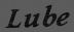

original image width:82, height:31
target_img_size:(84, 32)
display image shape : (84, 32, 3)
label : Spencerian


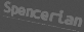

original image width:115, height:31
target_img_size:(100, 32)
display image shape : (100, 32, 3)
label : accommodatingly


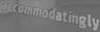

original image width:140, height:31
target_img_size:(100, 32)
display image shape : (100, 32, 3)
label : CARPENTER


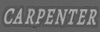

In [12]:
from IPython.display import display

# env에 데이터를 불러온다.
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적
env = lmdb.open(TRAIN_DATA_PATH,
                max_readers=32,
                readonly=True,
                lock=False,
                readahead=False,
                meminit=False)

# 불러오느 데이터를 txn(transaction)이라는 변수를 통해 연다.
# txn 변수를 통해 직접 데이터에 접근할 수 있음.
with env.begin(write=False) as txn:
    for index in range(1,5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있다.
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요
        try:
            img = Image.open(buf).convert('RGB')
        
        except IOError:
            img = Image.new('RGB', (100,32))
            label = '-'

        # 원본 이미지 크기를 출력해 보자
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))

        # 이미지 비율을 유지하면서 높이를 32로 바꾼다.
        # 하지만 너비를 100보다는 작게하기로 한다.
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)
        print('target_img_size:{}'.format(target_img_size))
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
#         img = np.array(img.resize(target_img_size))

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있다.
        print('display image shape : {}'.format(img.shape))
        print('label : {}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

### class MJDatasetSequence

- `lmdb`를 사용하여 케라스 모델 학습용 MJSynth 데이터셋 클래스를 구현해본다.

In [13]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

<br> 

## **Recognition Model (2) Encode**
---

In [14]:
class LabelConverter(object):
    
    def __init__(self, character):
        self.character = '-' + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i
            
    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)   # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)
    
    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ''
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

***위 코드가 정상 동작하는지 'Hello'를 입력하여 확인해보자***

In [15]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encoded_text = label_converter.encode('HELLO')
print('Encoded_text:', encoded_text)
decoded_text = label_converter.decode(encoded_text)
print('Decoded_text:', decoded_text)

Encoded_text: [ 8  5 12  0 12 15]
Decoded_text: HEL-LO


<br>

## **Recognition Model (3)Build CRNN model**
---

- 이제 입력과 출력을 준비했으니, 모델을 만들어보자.
- `Keras`에서 제공하는 `K.ctc_batch_cost()`를 활용해서 loss를 계산하도록 `ctc_lambda_func`를 아래와 같이 만든다.

<br>

In [16]:
def ctc_lambda_func(args):  # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [17]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
#     y_func = tf.keras.backend.function(image_input, [y_pred])
    return model

<br>

## **Recognition Model (5) Train & Inference**
---

In [18]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [12]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
checkpoint_path = HOME_DIR + '/model_checkpoint_100epochs.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=100,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/100
565/565 [==============================] - 97s 151ms/step - loss: 25.2941 - val_loss: 23.2347

Epoch 00001: val_loss improved from inf to 23.23469, saving model to /aiffel/aiffel/ocr/model_checkpoint_100epochs.hdf5
Epoch 2/100
565/565 [==============================] - 85s 150ms/step - loss: 13.8566 - val_loss: 8.9742

Epoch 00002: val_loss improved from 23.23469 to 8.97416, saving model to /aiffel/aiffel/ocr/model_checkpoint_100epochs.hdf5
Epoch 3/100
565/565 [==============================] - 85s 150ms/step - loss: 6.7851 - val_loss: 6.3263

Epoch 00003: val_loss improved from 8.97416 to 6.32630, saving model to /aiffel/aiffel/ocr/model_checkpoint_100epochs.hdf5
Epoch 4/100
565/565 [==============================] - 84s 149ms/step - loss: 4.9264 - val_loss: 5.5093

Epoch 00004: val_loss improved from 6.32630 to 5.50930, saving model to /aiffel/aiffel/ocr/model_checkpoint_100epochs.hdf5
Epoch 5/100
565/565 [==============================] - 84s 149ms/step - loss: 3.9207 - 

In [19]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
# checkpoint_path = HOME_DIR + '/data/model_checkpoint_100epochs.hdf5'
checkpoint_path = HOME_DIR + '/model_checkpoint_100epochs.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 


In [20]:
input_data = model.get_layer('input_image').output
input_data

<KerasTensor: shape=(None, 100, 32, 3) dtype=float32 (created by layer 'input_image')>

In [21]:
y_pred = model.get_layer('output').output
y_pred

<KerasTensor: shape=(None, 24, 38) dtype=float32 (created by layer 'output')>

In [22]:
model_pred = Model(inputs=input_data, outputs=y_pred)
model_pred.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 32, 3)]      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 32, 64)       1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 8, 128)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 25, 8, 256)        295168    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 8, 256)        5900

<br>

**학습된 모델의 성능을 눈으로 확인해보자**

<br>

Result: 	 SLINKING9999999999999999


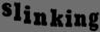

Result: 	 ALEPPO99999999999999999


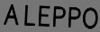

Result: 	 RWENDE999999999999999999


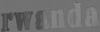

Result: 	 MATHANS99999999999999999


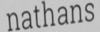

Result: 	 HALO99999999999999999999


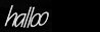

Result: 	 HURLS9999999999999999999


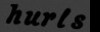

Result: 	 DOWNSIZE9999999999999999


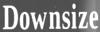

Result: 	 ROBOTIC99999999999999999


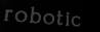

Result: 	 SLOPPY99999999999999999


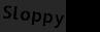

Result: 	 HERMITE99999999999999999


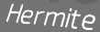

In [23]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 한다.
# 코드 하나하나를 이해하기는 조금 어려울 수 있다.
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False, beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ''
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행한다.
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해준다.
def check_inference(model, dataset, index=5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars='-'+TARGET_CHARACTERS)[0].replace('-','')
        print('Result: \t', result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))
        
check_inference(model_pred, test_set, index=10)

<br>

## **Detection Model : 해당 이미지 내의 문자 찾아내기**
---

In [45]:
import cv2
import matplotlib.pyplot as plt
from keras_ocr.detection import Detector
from PIL import Image, ImageDraw

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [126]:
def detect_text(img_path, detector):
    
    # 이미지 불러오기
    img_pil = Image.open(img_path).convert('RGB')  # (1200, 900, 3)

    # 1. Keras-OCR 의 Detection 모델에 입력하기 위한 이미지 전처리
    # - 이미지 비율 유지해서 resize() 적용
    # - 배치 크기 때문에 4 dims 로 확장
    # - shape=(H,W,C) 여야 모델 입력시 제대로 동작함
    width, height = img_pil.size  # 원본 이미지 크기
    target_width = min(int(width*300/height), 400)  # 이미지 비율 유지, 높이 300, 너비는 400 보다 작게 설정
    target_img_size = (target_width,300)

    img_pil = img_pil.resize(target_img_size)  # (400, 300, 3)
    img_pil_copy = img_pil.copy()

    img_pil = np.array(img_pil)  # (300, 400, 3)
    img_pil = np.expand_dims(img_pil, axis=0)  # (1, 300, 400, 3)
    
    # 2. 모델 예측
    # - OCR 텍스트 검출 결과
    # - 배치 첫 번째 결과 가져오기
    detect_result = detector.detect(img_pil)  # 타입: list
    ocr_result = detect_result[0]  # 타입: np.array

    # 3. display() 하기 위한 이미지 전처리
    # - 앞서 4 dims 로 확장시켰으므로 다시 3 dims 가 되도록 축소
    # - shape=(H,W,C) 여야 display() 에서 이미지가 제대로 그려짐
    img_pil = np.squeeze(img_pil, axis=0).astype(np.uint8)  # (300, 400, 3)
    img_pil = Image.fromarray(img_pil)
    img_draw = ImageDraw.Draw(img_pil)
#     img_draw.line(ocr_result[0], fill='blue', width=10)
#     img_draw.line(ocr_result[1], fill='blue', width=10)

    cropped_imgs = []  # 단어 영역
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil_copy.crop(word_box))
    
    return img_pil, cropped_imgs

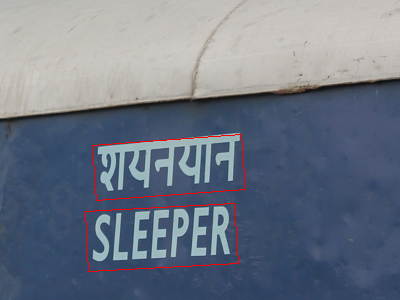

In [127]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH, detector)
display(img_pil)

In [128]:
print(ocr_result.shape)
ocr_result

(2, 4, 2)


array([[[ 92.815384, 145.53885 ],
        [241.28029 , 134.40399 ],
        [245.38594 , 189.14606 ],
        [ 96.921036, 200.28091 ]],

       [[ 85.35361 , 211.7182  ],
        [234.93924 , 203.84528 ],
        [238.07736 , 263.4696  ],
        [ 88.49173 , 271.34253 ]]], dtype=float32)

In [132]:
TARGET_CHARACTERS

'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

In [139]:
def recognize_img(idx, pil_img, model_pred, input_img_size=(100,32)):
    # CRNN 기반의 Recognition 모델에 입력하기 위한 이미지 전처리
    # - 배치 크기 때문에 4 dims 로 확장
    # - shape=(W,H,C) 여야 모델 입력시 제대로 동작함
    pil_img = pil_img.resize(input_img_size)  # (100, 32, 3)
    pil_img = np.array(pil_img)  # (32, 100, 3)
    pil_img = pil_img.transpose(1,0,2)  # (100, 32, 3)
    pil_img = np.expand_dims(pil_img, axis=0)  # (1, 100, 32, 3)
    
    # 모델 예측
    # - OCR 텍스트 인식 결과 출력
    output = model_pred.predict(pil_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    
    # display() 하기 위한 이미지 전처리
    # - 앞서 4 dims 로 확장시켰으므로 다시 3 dims 가 되도록 축소
    # - shape=(H,W,C) 여야 display() 에서 이미지가 제대로 그려짐
    pil_img = np.squeeze(pil_img, axis=0).transpose(1,0,2).astype(np.uint8)  # (32, 100, 3)
    pil_img = Image.fromarray(pil_img)
#     pil_img.save(f'result/Text_Recognition_{idx}.png')  # 저장
    display(pil_img)

In [140]:
def end_to_end_ocr(img_path, detector, model_pred):
    # Text Detection
    print('━━━━━━━━ Text Detection ━━━━━━━━')
    img_pil, cropped_img = detect_text(img_path, detector)
#     img_pil.save(f'result/sample.png')  # 저장
    display(img_pil)

    # Text Recognition
    print('━━━━━━━━ Text Recognition ━━━━━━━━')
    for idx, _img in enumerate(cropped_img):
        recognize_img(idx, _img, model_pred)

━━━━━━━━ Text Detection ━━━━━━━━


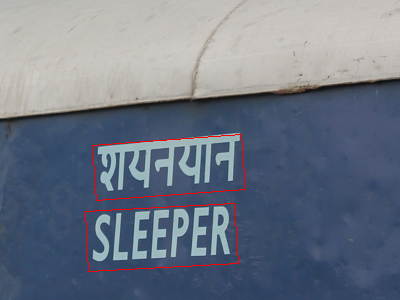

━━━━━━━━ Text Recognition ━━━━━━━━
Result: 	 TURIA9999999999999999999


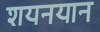

Result: 	 ISLEEPER999999999999999


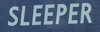

In [144]:
end_to_end_ocr(SAMPLE_IMG_PATH, detector, model_pred)

━━━━━━━━ Text Detection ━━━━━━━━


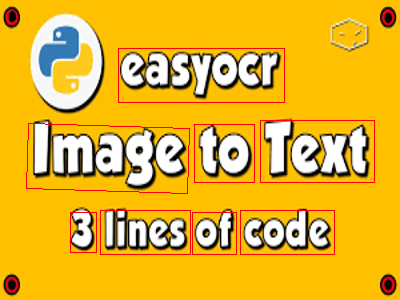

━━━━━━━━ Text Recognition ━━━━━━━━
Result: 	 REASYOEH9999999999999999


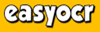

Result: 	 AEY999999999999999999999


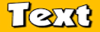

Result: 	 AFIHSES99999999999999999


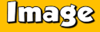

Result: 	 THIAY99999999999999999


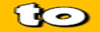

Result: 	 VICBLN999999999999999999


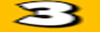

Result: 	 FIHEST999999999999999999


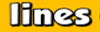

Result: 	 HASES999999999999999999


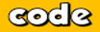

Result: 	 TRASHL999999999999999999


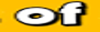

In [145]:
SAMPLE_IMG_PATH = HOME_DIR + '/sample1.jpg'
end_to_end_ocr(SAMPLE_IMG_PATH, detector, model_pred)

━━━━━━━━ Text Detection ━━━━━━━━


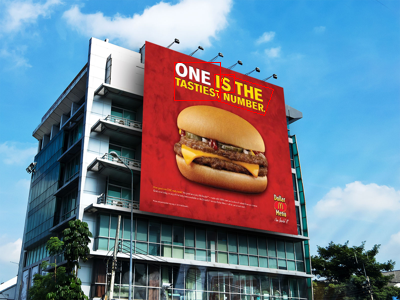

━━━━━━━━ Text Recognition ━━━━━━━━
Result: 	 TAPAR999999999999999999


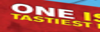

Result: 	 TOPIS9999999999999999999


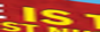

Result: 	 HEANT9999999999999999999


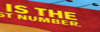

In [147]:
SAMPLE_IMG_PATH = HOME_DIR + '/sample3.jpg'
end_to_end_ocr(SAMPLE_IMG_PATH, detector, model_pred)

━━━━━━━━ Text Detection ━━━━━━━━


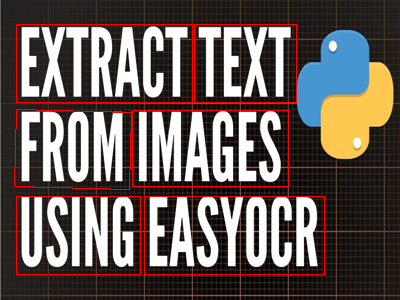

━━━━━━━━ Text Recognition ━━━━━━━━
Result: 	 EXTRACT99999999999999999


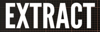

Result: 	 TEXT99999999999999999999


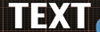

Result: 	 FROM99999999999999999999


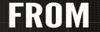

Result: 	 IMAGES999999999999999999


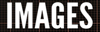

Result: 	 USING9999999999999999999


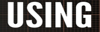

Result: 	 EASYOGR99999999999999999


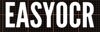

In [146]:
SAMPLE_IMG_PATH = HOME_DIR + '/sample2.jpg'
end_to_end_ocr(SAMPLE_IMG_PATH, detector, model_pred)

<br>

## 회고
---

- 사진의 해상도가 좋고 글자의 크기가 비교적 큰 이미지에서 OCR 결과가 정확하게 나오는 것을 확인 할 수 있다.
- 또한, 일반적인 글자가 아닌 약간의 모양이 변형된(굵기변화, 종횡비 변화) 경우 recognition 인식률이 낮게 나타남을 보였다.


-  Detection 모델을 만들때 다음의 깃헙 내용을 참고하였다. [github 참고]('https://github.com/HRPzz/AIFFEL/blob/main/GOING_DEEPER_CV/Node_12/%5BCV-12%5D%20Recognition_CRNN_of_Keras_OCR.ipynb')